In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import caiman as cm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

### 1. Load data

In [2]:
imgStack = np.load('imgDMotion.npy')

### 1.1 Crop time series data, ranged as x, y, t

In [3]:
Frame = imgStack#[:, 100:300,50:150]
Y = np.asarray(Frame)
Y = Y.transpose([1,2,0])
dims = Y.shape
Y_rm = Y.reshape((np.prod(dims[:2]),dims[2]),order='F')

### 2. Detrend raw signal

#### 2.1 Temporal downsampling
This could be set later in the code using pre_svd.svd_patch
```python
import spatialDenoising.preprocess_blockSVD as pre_svd
ts = 5
Y_rm = pre_svd.temporal_decimation(Y_rm.T,ts).T
```

In [ ]:
# from spatialDenoising.trefide import detrend
# this is a very slow code.....
from spatialDenoising.utils import detrend
from spatialDenoising.tools import remove_trend
Y_det, offset = remove_trend(Y_rm)
Y_detr = Y_det.reshape((dims[0],dims[1])+(dims[2],),order='F')
np.save('Y_detr', Y_detr)

In [3]:
Y_detr = np.load('Y_detr.npy')

### 3.1 Spatial wiener filter smooth over a boxed neighbour with half length gHalf

In [5]:
from spatialDenoising.spatial_filtering import spatial_filter_image
# neighbors
k = 4
gHalf = np.array([k,k]) // 2

In [6]:
%%time
Y_wf, _ = spatial_filter_image(Y_detr,gHalf=gHalf)

first k pixels 0
first k pixels 1000
first k pixels 2000
first k pixels 3000
first k pixels 4000
first k pixels 5000
first k pixels 6000
first k pixels 7000
first k pixels 8000
first k pixels 9000
first k pixels 10000
first k pixels 11000
first k pixels 12000
first k pixels 13000
first k pixels 14000
first k pixels 15000
first k pixels 16000
first k pixels 17000
first k pixels 18000
first k pixels 19000
first k pixels 20000
first k pixels 21000
first k pixels 22000
first k pixels 23000
first k pixels 24000
first k pixels 25000
first k pixels 26000
first k pixels 27000
first k pixels 28000
first k pixels 29000
first k pixels 30000
first k pixels 31000
first k pixels 32000
first k pixels 33000
first k pixels 34000
first k pixels 35000
first k pixels 36000
first k pixels 37000
first k pixels 38000
first k pixels 39000
first k pixels 40000
first k pixels 41000
first k pixels 42000
first k pixels 43000
first k pixels 44000
first k pixels 45000
first k pixels 46000
first k pixels 47000
first

In [8]:
np.save('Y_wf', Y_wf)
Y_wf = np.load('Y_wf.npy')
mean_ = Y_wf.mean(axis=2,keepdims=True)
sn, psdx =cm.source_extraction.cnmf.pre_processing.get_noise_fft(Y_wf - mean_,noise_method='logmexp')
SNR_wf = Y_wf.var(2)/sn**2

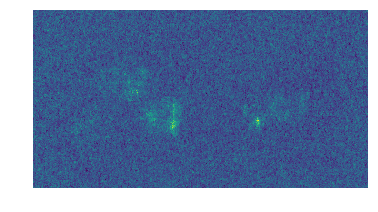

In [9]:
plt.imshow(SNR_wf)
plt.axis('off')
plt.show()

### 3.2 Spatial denoising using patched SVD (Greedy algorithm)

### 3.2.1. SVD Patch code

```python
svd_patch(image, k=1, maxlag=5, tsub=1, ds=1, noise_norm=False, iterate=False, confidence=0.99, corr=True, kurto=False, tfilt=False, tfide=False, share_th=True, plot_en=False, greedy=True, fudge_factor=0.9, mean_th=None, mean_th_factor=2.0, U_update=False, min_rank=1, verbose=False, pca_method='vanilla')
```

Given video M, partition video in k blocks and denoise/compress it as determined by the parameters.

----------

* image -- d1xd2xT
* k -- number of tiles in which to partition image along first 2 dimensions.
* maxlag: max correlation lag for correlation null hypothesis in samples (e.g. indicator decay in samples)
* tsub: temporal downsample constant
* ds: spatial downsample constant
* noise_norm: placeholder
* iterate: flag to include correlated components iteratively
* confidence: confidence interval (CI) for correlation null hypothesis
* corr: flag to include components which pass correlation null hypothesis
* kurto: flag to include components which pass kurtosis null hypothesis (*what is this in the model?*)
* tfilt: flag to temporally filter traces with AR estimate of order p (*what is this in the model?*)
* tfide: flag to denoise temporal traces with Trend Filtering (*what is this in the model?*)
* min_rank: minimum rank of denoised/compressed matrix; typically set to 1 to avoid empty output (array of zeros); if input array is mostly noise.
* greedy: flag to greedily update spatial and temporal components (estimated with PCA); greedyly by denoising temporal and spatial components (**what does greedy mean here?**)
* mean_th_factor: factor to scale mean_th; typically set to 2 if greedy=True and mean_th=None or if mean_th has not been scaled yet. (**Why default as 2? using 2 times mean as a threshold**)
* share_th: flag to compute a unique thredhold for correlation null hypothesis to be used in each tile. If false: each tile calculates its own mean_th value. (**If using global threshold**)
* fudge_factor: constant to scale estimated noise std st denoising st denoising is less (lower factor) or more (higher factor) restrictive. (**what???**)
* U_update: flag to (not) update spatial components by imposing **L1-constraint**. True for "round" neurons in 2p. False for dendritic data.
* plot_en: flag to enable plots
* pca_method: method for matrix decomposition (e.g. PCA, sPCA, rPCA, etc). see compute_svd for options

In [11]:
import spatialDenoising.preprocess_blockSVD as pre_svd
k =12
k = k**2
maxlag = 5
confidence = 0.95 # confidence has to change according to data length
tsub = 1
ds = 1
noise_norm = False
iterate = False 
corr = True
kurto = False
tfilt = False
share_th = True
tfide = False
plot_en = False
greedy=True
fudge_factor=0.9
mean_th=None
mean_th_factor=2.0
U_update=False
min_rank=1
verbose=True
pca_method='vanilla'

In [ ]:
%%time
Yd_detr, tot_rank, ranks = pre_svd.svd_patch(Y_detr, k=k, maxlag=maxlag, tsub=tsub, ds=ds, noise_norm=noise_norm, 
                                   iterate=iterate, confidence=confidence, corr=corr, kurto=kurto, tfilt=tfilt, 
                                   tfide=tfide, share_th=share_th, plot_en=plot_en, greedy=greedy, 
                                   fudge_factor=fudge_factor, mean_th=mean_th, mean_th_factor=mean_th_factor, 
                                   U_update=U_update, min_rank=min_rank, verbose=verbose, pca_method=pca_method)

Patch 0
Forcing one component
	Patch 0 run for 45
Patch 1
Forcing one component
	Patch 1 run for 42
Patch 2
Forcing one component
	Patch 2 run for 41
Patch 3
Forcing one component
	Patch 3 run for 41
Patch 4
Forcing one component
	Patch 4 run for 41
Patch 5
Forcing one component
	Patch 5 run for 41
Patch 6
Forcing one component
	Patch 6 run for 40
Patch 7
Forcing one component
	Patch 7 run for 41
Patch 8
Forcing one component
	Patch 8 run for 39
Patch 9
Forcing one component
	Patch 9 run for 40
Patch 10
Forcing one component
	Patch 10 run for 40
Patch 11
Forcing one component
	Patch 11 run for 40
Patch 12
Forcing one component
	Patch 12 run for 41
Patch 13
Forcing one component
	Patch 13 run for 40
Patch 14
Forcing one component
	Patch 14 run for 41
Patch 15
Forcing one component
	Patch 15 run for 41
Patch 16
Forcing one component
	Patch 16 run for 41
Patch 17
Forcing one component
	Patch 17 run for 42
Patch 18
Forcing one component
	Patch 18 run for 40
Patch 19
Forcing one component
	

In [9]:
np.save('Yd_detr', Yd_detr)
np.save('Yd_detr_ranks', ranks)

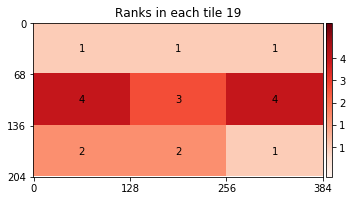

In [10]:
Yd_detr = np.load('Yd_detr.npy')
ranks = np.load('Yd_detr_ranks.npy')
blocks = pre_svd.split_image_into_blocks(Y_detr, number_of_blocks=k)
dimsMc = list(map(np.shape,blocks))
dimsM = Y_detr.shape
Cplot3 = pre_svd.cn_ranks_plot(dimsMc, ranks, dimsM[:2])

### 3.2.2 SVD patch node with L1 constraint

In [ ]:
# U_update=True
# Y_detr = np.load('Y_detr.npy')

In [ ]:
# %%time
# Yd_detrt, tot_rank, ranks = pre_svd.svd_patch(Y_detr, k=k, maxlag=maxlag, tsub=tsub, ds=ds, noise_norm=noise_norm, 
#                                    iterate=iterate, confidence=confidence, corr=corr, kurto=kurto, tfilt=tfilt, 
#                                    tfide=tfide, share_th=share_th, plot_en=plot_en, greedy=greedy, 
#                                    fudge_factor=fudge_factor, mean_th=mean_th, mean_th_factor=mean_th_factor, 
#                                    U_update=U_update, min_rank=min_rank, verbose=verbose, pca_method=pca_method)

In [ ]:
# # CPU times: user 2h 15min 35s, sys: 24min 4s, total: 2h 39min 40s, Wall time: 58min 28s
# np.save('Yd_detrt', Yd_detrt)
# np.save('Yd_detrt_ranks', ranks)

In [ ]:
Yd_detrt = np.load('Yd_detrt.npy')
ranks = np.load('Yd_detrt_ranks.npy')
blocks = pre_svd.split_image_into_blocks(Y_detr, number_of_blocks=k)
dimsMc = list(map(np.shape,blocks))
dimsM = Y_detr.shape
Cplot3 = pre_svd.cn_ranks_plot(dimsMc, ranks, dimsM[:2])

### 3.2.3 Interpolation of the results

1. What to do if there is an **error message**
> ERROR: Greedy solving failed, using default parameters
2. How to specify the degree of sparseness? Is the hyper-parameter $\lambda$ is optimal?

### 4 Summary results -- comparison

#### Results variable names:
* Y: raw data
* offset: slow trend
* Y_detr: Y - offset 
* Yd_detr: Y_detr denoised PCA
* Yd_detrt: Y_detr denoised PCA + L1T
* Y_wf: Y_detr denoised spatially WF
* Yd_wfr: Yd_wf (Y_detr denoised spatially WF) then denoised PCA
* Yd_wft: Yd_wf (Y_detr denoised spatially WF) then denoised PCA + L1T

### 4.1 Denoised images vs raw image

In [14]:
tmp_ = [Y_detr, Y_wf, Yd_detr] #, Yd_detrt
titles = ['Raw data', 'Local WF', 'Local sPCA']#, 'Local sPCA-L1'

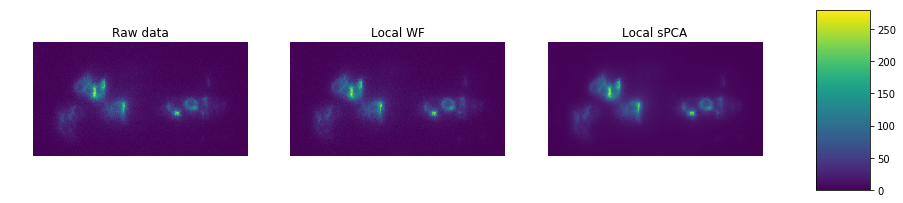

In [22]:
f, ax = plt.subplots(1, len(tmp_), figsize=(15, 5))
for nPlt in range(len(tmp_)):
    cf = ax[nPlt].imshow(tmp_[nPlt][:, :, 0], vmin=0, vmax=280)
    ax[nPlt].set_title(titles[nPlt])
    ax[nPlt].axis('off')
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.25, 0.05, 0.5])
f.colorbar(cf, cax=cbar_ax)
plt.savefig('kelly_denoise_img.png', dpi=700, bbox_inches="tight")
plt.show()

In [ ]:
crop_x = (0, 20)
crop_y = (65, 90)
mask = np.zeros(Y_detr.shape[:2])
mask[crop_x[0]:crop_x[1], crop_y[0]:crop_y[1]] = 1

In [ ]:
cropRaw = Y_detr[mask==1, 0]
cropSDN = Yd_detr[mask==1, 0]
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cropRaw.reshape(20, 25))
ax1.set_title('Raw image')
ax1.axis('off')
ax2.imshow(cropSDN.reshape(20, 25))
ax2.set_title('Denoised image')
ax2.axis('off')
plt.show()

In [ ]:
f, ax = plt.subplots(1)
for nPlt in range(len(tmp_)):
    ax.plot(tmp_[nPlt][mask==1, :].mean(axis=0), label=titles[nPlt], alpha=0.5)
plt.legend()
plt.xlim([0, 500])
plt.savefig('kelly_denoise_F.png', dpi=700, bbox_inches="tight")
plt.show()

In [ ]:
crop_x = (0, 10)
crop_y = (80, 90)
mask = np.zeros(Y_detr.shape[:2])
mask[crop_x[0]:crop_x[1], crop_y[0]:crop_y[1]] = 1
cropRaw = Y_detr[mask==1, 0]
cropSDN = Yd_detr[mask==1, 0]
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(cropRaw.reshape(10, 10))
ax1.set_title('Raw image')
ax1.axis('off')
ax2.imshow(cropSDN.reshape(10, 10))
ax2.set_title('Denoised image')
ax2.axis('off')
plt.show()

In [ ]:
f, ax = plt.subplots(1)
for nPlt in range(len(tmp_)):
    ax.plot(tmp_[nPlt][mask==1, :].mean(axis=0), label=titles[nPlt], alpha=0.5)
plt.legend()
plt.xlim([0, 200])
plt.savefig('kelly_denoise_F.png', dpi=700, bbox_inches="tight")
plt.show()

### 4.2 SNR

In [ ]:
f, ax = plt.subplots(1, len(tmp_), figsize=(15, 5))
for nPlt in range(len(tmp_)):
    Y_ = tmp_[nPlt]
    mean_ = Y_.mean(axis=2,keepdims=True)
    sn, psdx =cm.source_extraction.cnmf.pre_processing.get_noise_fft(Y_ - mean_,noise_method='logmexp')
    SNR_ = Y_.var(2)/sn**2
    cf = ax[nPlt].imshow(np.log(SNR_), vmin=0.4, vmax=3.5)
    ax[nPlt].set_title(titles[nPlt])
    ax[nPlt].axis('off')
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.25, 0.05, 0.5])
f.colorbar(cf, cax=cbar_ax)
# plt.savefig('kelly_denoise_snr.png', dpi=700, bbox_inches="tight")
plt.show()

### 4.3 Local correlations

In [ ]:
f, ax = plt.subplots(1, len(tmp_), figsize=(15, 5))
for nPlt in range(len(tmp_)):
    Y_ = tmp_[nPlt]
    cf = ax[nPlt].imshow(cm.local_correlations(Y_), vmin=0, vmax=1)
    ax[nPlt].set_title(titles[nPlt])
    ax[nPlt].axis('off')
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.25, 0.05, 0.5])
f.colorbar(cf, cax=cbar_ax)
# plt.savefig('kelly_denoise_local_corr.png', dpi=700, bbox_inches="tight")
plt.show()

### 4.4 Other comparisons

* Computational time vs length of signal
* With or without L1 constraint


### 5. Other tools:

#### trefide.py
* **detrend**(signals, degree=2): **Substracts the order k trend from each input pixel**
* **estimate_noise**(signals, estimator='pwelch', summarize='logmexp', freq_range=[0.25, 0.5], max_samples_fft=3072, num_samples_boot=1000, len_samples_boot=25): **Estimate the standard deviation of the noise contaminating temporal signals using either fft (average over high frequency components of the FFT), pwelch (average over high frequency components of Welch's PSD estimate), boot (bootstrap estimates of the mse of linear fits to small subsamples of the signal; only appropriate when signal is approximately piecewise linear)); Method of averaging the power spectrum/bootstrap sample: 'mean': Mean,'median': Median,'logmexp': Exponential of the mean of the logs**
* **detect_regions**(signal, stdv=None, noise_estimator='pwelch', noise_summarizer='logmexp',noise_max_samples_fft=3072, noise_freq_range=[0.25, 0.5],noise_num_samples_boot=1000, noise_len_samples_boot=25, filter_cutoff=100, filter_fs=10000.0, filter_order=6, thresh_min_consec=2, thresh_min_pnr=5, active_min_gap=400, active_buffer=50,active_discount=0): **Partition input signal into regions dominated by spiking activity and subthreshold activity. Active regions are detected by thresholding the highpass activity (extracted with butterworth filter) of the input signal.**
